# Ex09

In [ ]:
! pip install --upgrade tensorflow==2.6.0
! pip install --upgrade keras==2.6.0

In [ ]:
import tensorflow
import keras

print(tensorflow.__version__)
print(keras.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install --upgrade pixellib==0.7.1

In [5]:
import cv2
import urllib
import pixellib
import numpy as np
from pixellib.semantic import semantic_segmentation
from pixellib import semantic
from matplotlib import pyplot as plt

### Step 1. 인물모드 직접 해 보기

In [6]:
img_path = '/content/drive/MyDrive/김태리강아지.jfif'
img_orig = cv2.imread(img_path)

<function matplotlib.pyplot.show(*args, **kw)>

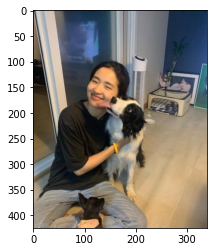

In [7]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show

세그멘테이션을 하기 위해, DeepLab 모델을 다운받아야 한다.

In [8]:
# 파일 저장
model_file = '/content/drive/MyDrive/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
model_url = model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f2f8fa41f50>)

In [9]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [10]:
# 모델 이미지 등록
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL 색깔로 사진 구별

In [11]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

사람은 15, 강아지는 12번째 인덱스에 있다는 것을 확인할 수 있다.

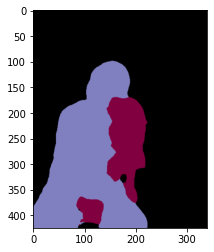

In [12]:
plt.imshow(output)
plt.show()

In [13]:
segvalues

{'class_ids': array([ 0, 12, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [14]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog
person


오잉 ?! 강아지랑, 사람 전부 다 잘 인식하고 있다.

사람과 강아지 무슨 색으로 구분되어 있는 지 확인해 보자.

In [15]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [16]:
# 사람, 강아지 색상 확인
print(colormap[15])
print(colormap[12])

[192 128 128]
[ 64   0 128]


### 사람만 인식시켜보기

In [17]:
# BGR -> RGB
seg_color = (128, 128, 192)
seg_color2 = (128, 0, 64)

이제 seg_color로만 이루어진 마스크를 만들어 보자.
3채널 가졌던 원본과는 다르게 채널 정보가 사라졌다.
이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.
원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것이다.

(425, 340)


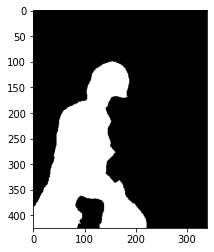

In [18]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

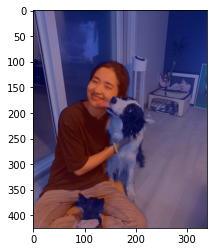

In [19]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

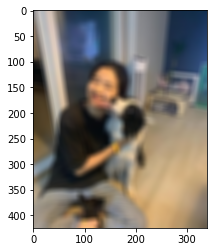

In [20]:
# 전체 블러처리 하기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

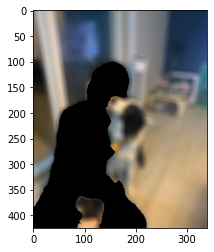

In [21]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

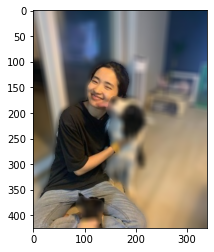

In [22]:
# 배경과 사람을 합쳐 인물사진 완성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 강아지만 인식시켜보기



(425, 340)


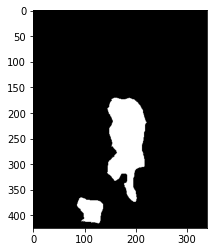

In [23]:
seg_map = np.all(output==seg_color2, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

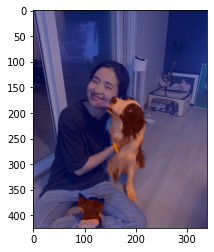

In [24]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

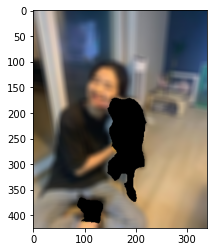

In [26]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

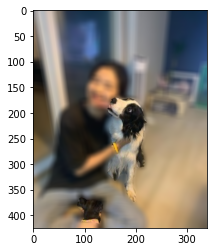

In [27]:
# 배경과 사람을 합쳐 인물사진 완성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 사람과 동물 둘 다

(425, 340)


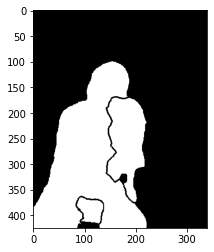

In [28]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
seg_map2 = np.all(output==seg_color2, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map + seg_map2, cmap='gray')

plt.show()

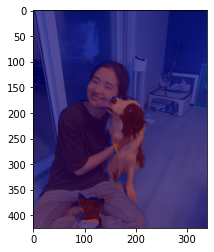

In [29]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
img_mask2 = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
img_show = cv2.addWeighted(img_show, 0.6, color_mask2, 0.4, 0.0) 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

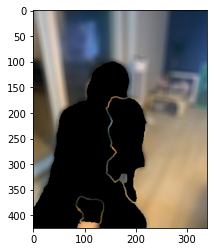

In [30]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) + cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) 
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

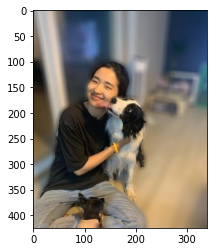

In [31]:
# 배경과 사람을 합쳐 인물사진 완성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점, 회고

앞서 노드에서 경고한 것과는 다르게 원하는 부분만 잘 인식하고 있다. 사람, 동물, 그리고 사람과 동물 다양한 방법으로 시도해보았다. 3사진 전부 다 원하는 부분만 잘 보여지고 있다. 그래서 뚜렷하게 보이는 문제점은 없었다. 하지만, 완성된 사진을 실사용에 쓸 수있을까? 라는 의문을 제기한다면, 쉽게 대답할 자신이 없다. 목표물이 원본사진보다 화질이 떨어진다는 느낌이 들기 때문이다. 원하는 부분을 다른 배경보다 뚜렷하게 하기 위한 작업인데, 정작 원하는 부분도 선명도가 떨어지는 거 같아 아쉬웠다. 주위 환경은 블러처리하고 목표물이 좀 더 선명해지는 기술을 개발이 시급한 거 같다.

인터넷에 검색해본 결과 다양한 화질 높이는 방법이 잇다. 그 중에서도 컨볼루션 신경망(CNN)을 통한 머신러닝도 이중 한 방법이다. 코드 몇 줄이면 이를 해결할 수 있다는 생각이 든다. 이 방법은 다음에 꼭 구현해보도록 하겠다.

화질 높이기
http://waifu2x.udp.jp/index.ko.html